In [1]:
import pandas as pd
import numpy as np
import glob
import re
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc #한글지원
import platform
import warnings
warnings.filterwarnings(action='ignore')
import seaborn as sns
plt.rc("font",family='Malgun Gothic') #한글_글꼴
plt.rcParams['axes.unicode_minus'] = False #음수표시

# 파일 읽어오기

In [4]:
# 증상백과
df_s = pd.read_excel('../data/증세/arm_total.xlsx', usecols='C:D')
display(df_s.shape, df_s[:5])

(183, 2)

,증상명,병명
0,가늘어지는 팔다리,니만-피크병(Niemann-Pick disease)
1,가늘어지는 팔다리,쿠싱 증후군(Cushing's syndrome)
2,관절 운동성 감소,골관절염(Osteoarthritis)
3,관절 운동성 감소,골괴사(Osteonecrosis)
4,관절 운동성 감소,무릎관절증(Gonarthrosis)


In [5]:
# 상병코드
kcd = pd.read_csv('../data/상병코드.csv', encoding='cp949', usecols=[0,1,2])
display(kcd.shape, kcd[:5])

(47798, 3)

,상병기호,한글명,영문명
0,A00,콜레라,Cholera
1,A000,비브리오 콜레라 01 콜레라형균에 의한 콜레라,Cholera due to Vibrio cholerae 01_ biovar chol...
2,A000,고전적 콜레라,Classical cholera
3,A001,비브리오 콜레라 01 엘토르형균에 의한 콜레라,Cholera due to Vibrio cholerae 01_ biovar eltor
4,A001,엘토르 콜레라,Cholera eltor


In [6]:
# 진료내역
df_t = None
for val in glob.glob('../data/진료내역/*.csv'):
    temp_t = pd.read_csv(val, encoding = 'euc-kr', usecols=[1, 6, 7, 8 , 9, 10, 11, 12, 17])
    temp_t = temp_t.astype({'서식코드':'category', '진료과목코드':'category'})
    df_t = pd.concat([df_t, temp_t])
display(df_t.shape, df_t[:5])

(11727248, 9)

,가입자 일련번호,요양개시일자,서식코드,진료과목코드,주상병코드,부상병코드,요양일수,입내원일수,총처방일수
0,29,2020-12-21,3,1,I109,E785,1,1,0
1,29,2020-12-14,3,1,I109,E785,1,1,7
2,255,2020-04-20,3,1,I109,I251,1,1,30
3,255,2020-04-16,3,1,I109,I251,1,1,30
4,2406,2020-12-30,3,1,I109,E780,1,1,0


In [37]:
# 건강검진
df_h = pd.read_csv('../plot/건강검진.CSV', encoding='euc-kr')
df_h = df_h.drop(['흡연상태', '음주여부', '치아우식증유무', '치석', '기준년도'], axis = 1)

# 결측치 평균값으로 대체
col_lis = list(df_h.columns[6:])

for col in col_lis:
    if col in col_lis[8:12]:
        df_mean = df_h.groupby(['체중(5Kg 단위)'])[col].transform('mean')   
    else:
        df_mean = df_h.groupby(['시도코드', '성별코드', '연령대 코드(5세단위)'])[col].transform('mean')

    df_h[col].fillna(df_mean, inplace=True)

# df_th용 copy df
df_h3 = df_h.copy()
idx_lis = list(set(df_t['가입자 일련번호']))
df_h3 = df_h3.set_index('가입자 일련번호')
df_h3 = df_h3.loc[idx_lis]

# 증상(병명) -> 상병코드 찾기

In [38]:
def Symptom(temp):
    p = re.compile('\(')
    p = p.search(temp).end()
    kcd_str = temp[p:-1]
    
    a = []
    
    for i in range(len(kcd)):
        if re.search(kcd_str.lower(), kcd['영문명'][i].lower()) != None:
            a.append(kcd['상병기호'][i])
            
    if len(a) == 0:
        a = '일치하는 상병기호가 없습니다'
            
    return a

In [39]:
Symptom('골관절염(Osteoarthritis)')

['M159', 'M47']

# 해당 상병코드를 가진 환자 건강검진 df 슬라이싱 -> 모델링용 df

In [10]:
kcd_str = Symptom('골관절염(Osteoarthritis)')

In [11]:
from sklearn.preprocessing import MinMaxScaler #정규화 
from sklearn.model_selection import train_test_split #train-test
from sklearn.model_selection import GridSearchCV #최적모델
from sklearn.metrics import confusion_matrix #오분류표

from sklearn.tree import DecisionTreeClassifier #의사결정나무
from sklearn.ensemble import BaggingClassifier #bagging
from sklearn.ensemble import RandomForestClassifier #randomforest
from sklearn.ensemble import GradientBoostingClassifier #boosting

from sklearn.tree import plot_tree #시각화

In [40]:
kcd_str2 = kcd_str[0]

### 모델링용 df생성 함수

def Df_th2(kcd_str2):
    df = df_t[(df_t['주상병코드'] == kcd_str2) | (df_t['부상병코드'] == kcd_str2)]

    df_th = pd.merge(df_h3, df[['가입자 일련번호', '주상병코드', '부상병코드']], on='가입자 일련번호', how='right')
    df_th = df_th.astype({'시도코드':'category', '성별코드':'category', '연령대 코드(5세단위)':'category'})

    # 수치형 변수들 정규화 (최소 0 ~ 최대 1)
    scaler = MinMaxScaler()

    # df_th2 : 연속형 변수들 표준화한 df
    df_th2 = df_th.copy()
    df_th2.iloc[:, 4:24] = scaler.fit_transform(df_th2.iloc[:, 4:24])

    # 종속변수 : 이분형 범주로 바꿈 (해당질명 -> 0:부상병, 1:주상병)
    df_th2['주상병'] = 0
    df_th2['주상병'][df_th2['주상병코드'] == kcd_str2] = 1
    
    return df_th2

# model

## df

In [41]:
df_th2 = Df_th2(kcd_str2)
display(df_th2.shape, df_th2[:5])

(21686, 28)

,가입자 일련번호,시도코드,성별코드,연령대 코드(5세단위),신장(5Cm단위),체중(5Kg 단위),허리둘레,시력(좌),시력(우),청력(좌),...,혈색소,요단백,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마 지티피,구강검진 수검여부,주상병코드,부상병코드,주상병
0,80670,경남,여자,60~64세,-0.651077,-0.285144,0.037369,0.150477,-0.215466,-0.233081,...,-1.267335,-0.234103,0.126881,0.377953,0.794040,-0.140448,1,I109,M159,0
1,111769,부산,여자,70~74세,-0.124278,-1.088527,-1.324927,0.150477,-0.059969,-0.233081,...,-0.548243,-0.234103,-0.185923,-0.402414,-0.547916,-0.300163,0,I109,M159,0
2,271654,서울,남자,60~64세,0.929319,0.518239,0.875704,-0.408902,0.095529,-0.233081,...,1.282173,-0.234103,-0.185923,-0.253773,0.081126,-0.360056,0,I109,M159,0
3,75671,대전,남자,60~64세,0.929319,1.321622,1.305351,0.523396,0.873016,-0.233081,...,0.628453,-0.234103,0.126881,-0.253773,-0.380172,-0.220305,0,I109,M159,0
4,75671,대전,남자,60~64세,0.929319,1.321622,1.305351,0.523396,0.873016,-0.233081,...,0.628453,-0.234103,0.126881,-0.253773,-0.380172,-0.220305,0,I109,M159,0


## 최적모형찾기

In [18]:
# 오분류표_함수.ver
def Matrix(mt, mt2):
    df_all = None
    for val in [mt, mt2]:
        hap = val.sum()
        a = (val[0][0] + val[1][1])/hap #정분류율
        b = (val[0][1] + val[1][0])/hap #오분류율
        d = val[1][1] / val.sum(axis=1)[1] #특이도
        c = val[0][0] / val.sum(axis=1)[0] #민감도
        col = ['정분류율', '오분류율', '민감도', '특이도']

        df1 = pd.DataFrame([a,b,c,d], columns=['오분류율'], index=col)
        df_all = pd.concat([df_all, df1], axis=1)
        
    df_all.columns = ['mt_train', 'mt_test']
    
    return df_all

In [42]:
# train : test = 7 : 3
X = df_th2.iloc[:,1:-3]
X = pd.get_dummies(X, drop_first=True) #범주형변수들 -> 더미변수
y = df_th2.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.3,
                                                   random_state=1234)

---------

In [46]:
class Model:
    def d_tree(re_temp = 0): #가장 예측력이 높은 값으로 뽑도록 defult값 설정
        # 최적화 찾기
        parameters = {'criterion' : ['entropy', 'gini'],
                      'max_depth': [3, 10, 50],
                      'min_samples_split': [round(len(df_th2)/100*i) for i in range(5,21,5)],
                      'splitter': ['best', 'random']}

        grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=1234),
                              param_grid = parameters,
                              cv = 3, # 교차검증
                              n_jobs = -1)

        grid_dt.fit(X_train, y_train)

        # 최적모델 df
        result = pd.DataFrame(grid_dt.cv_results_['params'])
        result['mean_test_score'] = grid_dt.cv_results_['mean_test_score']
        result = result.sort_values(by='mean_test_score', ascending=False)
        temp = list(result.iloc[re_temp]) #가장 예측율이 높은 값 리스트로 뽑기
        
        # 의사결정나무
        tree1 = DecisionTreeClassifier(criterion=temp[0],
             max_depth = temp[1],
             min_samples_leaf = temp[2],
             splitter = temp[3],
             random_state = 1234)

        # 오분류율
        tree1 = tree1.fit(X_train, y_train)
        y_train_pred = tree1.predict(X_train)
        y_test_pred = tree1.predict(X_test)

        mt_train = confusion_matrix(y_train, y_train_pred)
        mt_test = confusion_matrix(y_test, y_test_pred)
        
        return Matrix(mt_train, mt_test), result[:5], tree1
    
    def bagg(model_tree):
        # 최적화 찾기
        bc_params = {'bootstrap_features': [False, True],
                      'max_features': [0.5, 0.7, 1.0],
                      'max_samples': [0.5, 0.7, 1.0],
                      'n_estimators': [2, 5, 10, 20]}

        bc_gs = GridSearchCV(BaggingClassifier(model_tree), bc_params, cv=3, verbose=1)

        bc_gs.fit(X_train, y_train)

        # 최적모델 df
        result = pd.DataFrame(bc_gs.cv_results_['params'])
        result['mean_test_score'] = bc_gs.cv_results_['mean_test_score']
        result = result.sort_values(by='mean_test_score', ascending=False)
        
        # bagging
        bag = BaggingClassifier(base_estimator = model_tree,
                        bootstrap_features = False,
                        max_features = 0.7,
                        max_samples = 0.7,
                        n_estimators = 5)

        # 오분류율
        bag = bag.fit(X_train, y_train)
        y_train_pred = bag.predict(X_train)
        y_test_pred = bag.predict(X_test)

        mt_train = confusion_matrix(y_train, y_train_pred)
        mt_test = confusion_matrix(y_test, y_test_pred)
        
        return Matrix(mt_train, mt_test), result[:5], bag
    
    def rf(re_temp = 0):
        # 최적화 찾기
        rf_params = {'n_estimators' : [2, 5, 10, 20],
                     'min_samples_split' : [round(len(df_th2)/100*i) for i in range(5,21,5)],
                     'max_depth' : [3, 10, 50]}

        rf_gs = GridSearchCV(RandomForestClassifier(), rf_params, cv=3, verbose=1, n_jobs=-1)

        rf_gs.fit(X_train, y_train)

        # 최적모델 df
        result = pd.DataFrame(rf_gs.cv_results_['params'])
        result['mean_test_score'] = rf_gs.cv_results_['mean_test_score']
        result = result.sort_values(by='mean_test_score', ascending=False)
        temp = list(result.iloc[re_temp])

        # randomForest
        rf = RandomForestClassifier(max_depth = int(temp[0]),
                                    min_samples_leaf = int(temp[1]),
                                    n_estimators = int(temp[2]),
                                    random_state = 1234)

        # 오분류율
        rf = rf.fit(X_train, y_train)
        y_train_pred = rf.predict(X_train)
        y_test_pred = rf.predict(X_test)

        mt_train = confusion_matrix(y_train, y_train_pred)
        mt_test = confusion_matrix(y_test, y_test_pred)
        
        return Matrix(mt_train, mt_test), result[:5], rf

In [43]:
a,b,c = Model.d_tree()
print(a)
print(b)
print(c)

      mt_train   mt_test
정분류율  0.607378  0.601291
오분류율  0.392622  0.398709
민감도   0.106958  0.103911
특이도   0.951000  0.950798
   criterion  max_depth  min_samples_split splitter  mean_test_score
16   entropy         50               1084     best         0.618775
8    entropy         10               1084     best         0.616535
40      gini         50               1084     best         0.615020
32      gini         10               1084     best         0.612516
17   entropy         50               1084   random         0.611265
DecisionTreeClassifier(criterion='entropy', max_depth=50, min_samples_leaf=1084,
                       random_state=1234)


In [44]:
a,b,c = Model.d_tree()
Model.bagg(c)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


(      mt_train   mt_test
 정분류율  0.605072  0.600984
 오분류율  0.394928  0.399016
 민감도   0.152913  0.155307
 특이도   0.915556  0.914159,
     bootstrap_features  max_features  max_samples  n_estimators  \
 35               False           1.0          1.0            20   
 22               False           0.7          1.0            10   
 34               False           1.0          1.0            10   
 70                True           1.0          1.0            10   
 21               False           0.7          1.0             5   
 
     mean_test_score  
 35         0.610343  
 22         0.608762  
 34         0.607708  
 70         0.606324  
 21         0.606192  )

In [45]:
Model.rf()

Fitting 5 folds for each of 48 candidates, totalling 240 fits


(      mt_train   mt_test
 정분류율  0.592885  0.587304
 오분류율  0.407115  0.412696
 민감도   0.000000  0.000000
 특이도   1.000000  1.000000,
     max_depth  min_samples_split  n_estimators  mean_test_score
 33         50               1084             5                0
 34         50               1084            10                0
 35         50               1084            20                0
 18         10               1084            10                0
 17         10               1084             5                0)

## 모델링

## 의사결정나무

In [ ]:
a,b,tree1 = Model.d_tree()

# 변수중요도_시각화
temp = list(np.where(tree1.feature_importances_>0)[0])
plot_y = list(X.columns[temp])

sns.barplot(x=tree1.feature_importances_[tree1.feature_importances_>0], y=plot_y)
plt.show()

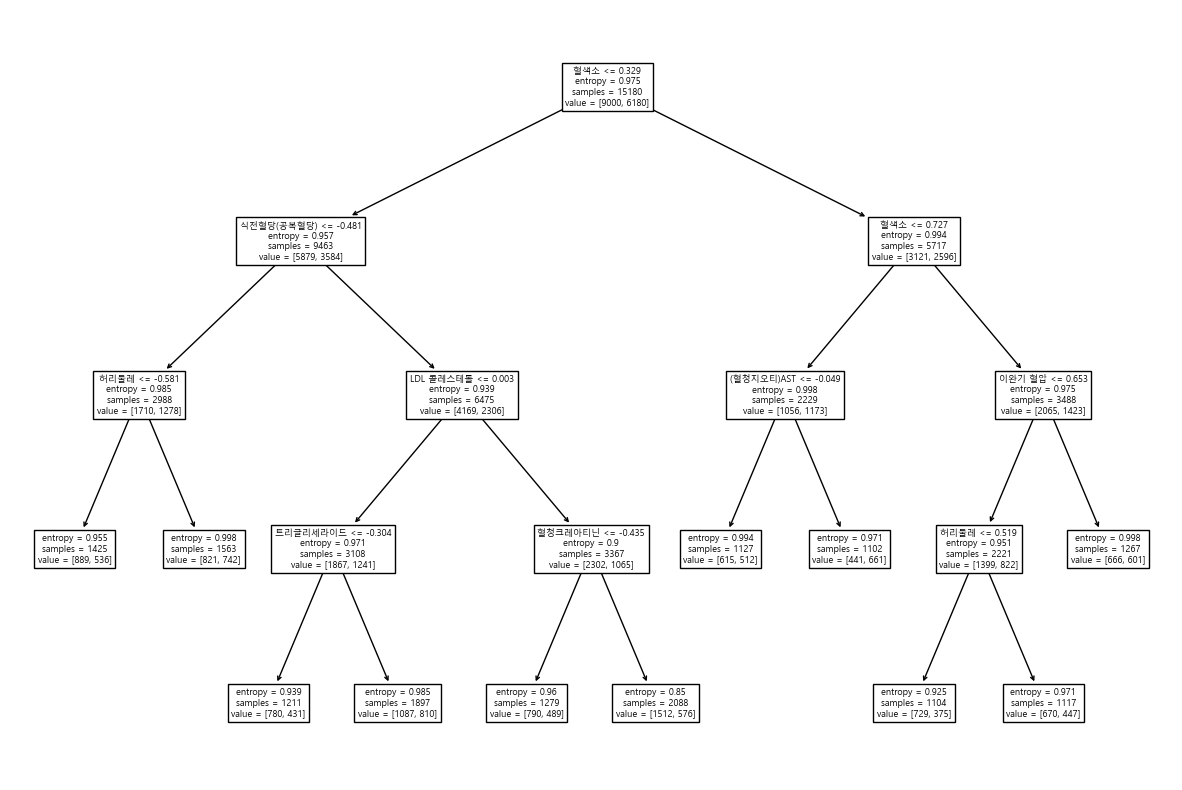

In [71]:
# 시각화
fig = plt.figure(figsize=(15, 10), facecolor='white')
plot_tree(tree1,
          feature_names=list(X.columns)
         )
plt.savefig('d_tree.png', dpi=300)

## 배깅

Fitting 5 folds for each of 72 candidates, totalling 360 fits


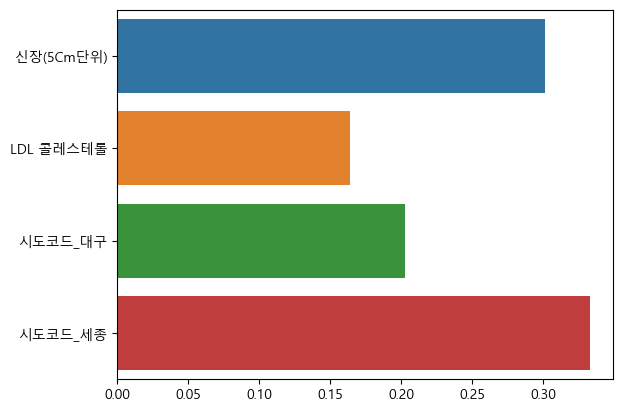

In [63]:
a,b,c = Model.d_tree()
a,b, bag = Model.bagg(c)

# 변수중요도_시각화
bag_np = bag.estimators_[0].feature_importances_
temp = list(np.where(bag_np>0)[0])
plot_y = list(X.columns[temp])

sns.barplot(x=bag_np[bag_np>0], y=plot_y)
plt.show()

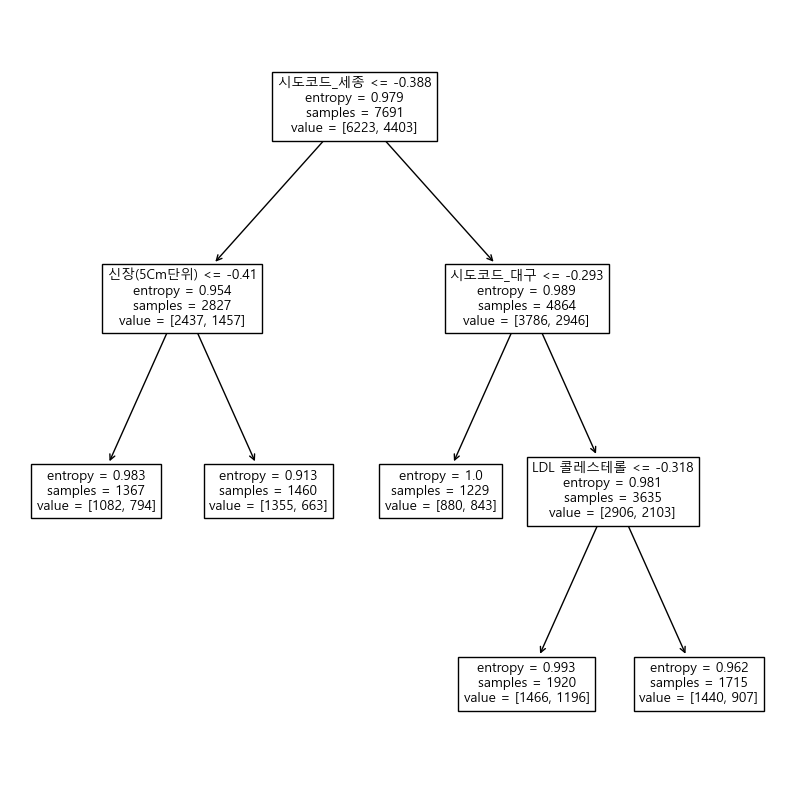

In [69]:
# 시각화
fig = plt.figure(figsize=(10, 10), facecolor='white')
plot_tree(bag.estimators_[0],
          feature_names=list(X.columns)
         )
plt.savefig('bagging.png', dpi=300)

## 랜덤포레스트

Fitting 5 folds for each of 48 candidates, totalling 240 fits


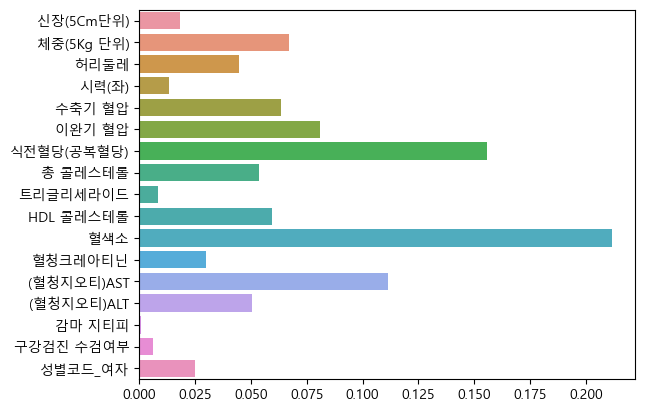

In [66]:
a,b, rf = Model.rf()

# 변수중요도_시각화
temp = list(np.where(rf.feature_importances_>0)[0])
plot_y = list(X.columns[temp])

sns.barplot(x=rf.feature_importances_[rf.feature_importances_>0], y=plot_y)
plt.show()

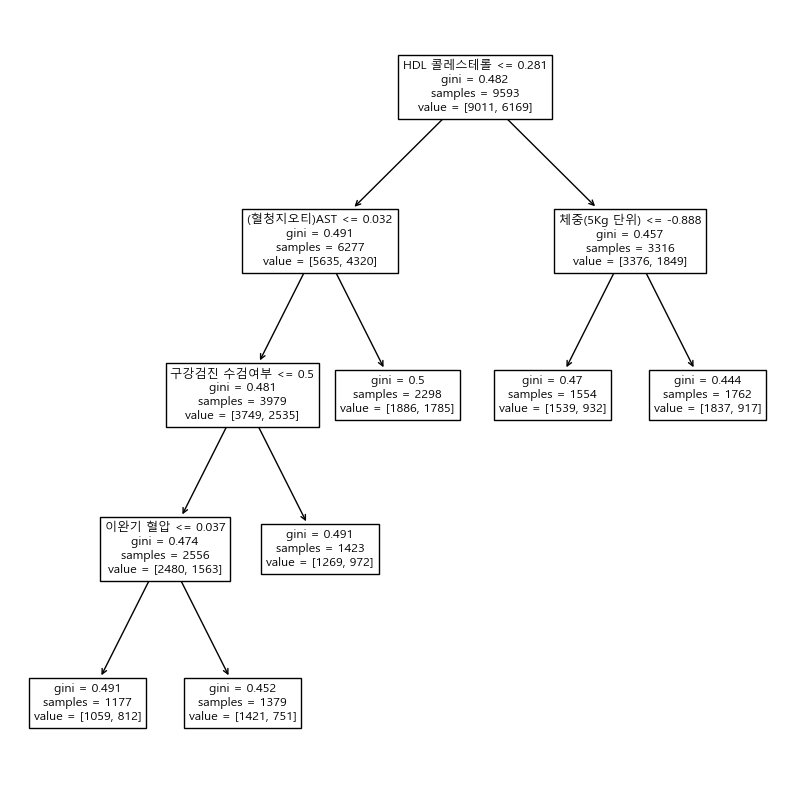

In [67]:
# 시각화
fig = plt.figure(figsize=(10, 10), facecolor='white')
plot_tree(rf.estimators_[0],
          feature_names=list(X.columns)
         )
plt.savefig('rf.png', dpi=300)

------

# 함수화 정리

In [ ]:
kcd_10 = pd.read_excel('./top10_주상병코드_질병명_2.xlsx', usecols=[1,2])
kcd_10 = kcd_10.iloc[[3,4,5,-1]]
display(kcd_10.shape, kcd_10[:5])

In [ ]:
def Df_th2(kcd_str2):
    df = df_t[(df_t['주상병코드'] == kcd_str2) | (df_t['부상병코드'] == kcd_str2)]

    df_th = pd.merge(df_h3, df[['가입자 일련번호', '주상병코드', '부상병코드']], on='가입자 일련번호', how='right')
    df_th = df_th.astype({'시도코드':'category', '성별코드':'category', '연령대 코드(5세단위)':'category'})

    # 수치형 변수들 정규화 (최소 0 ~ 최대 1)
    scaler = MinMaxScaler()

    # df_th2 : 연속형 변수들 표준화한 df
    df_th2 = df_th.copy()
    df_th2.iloc[:, 4:24] = scaler.fit_transform(df_th2.iloc[:, 4:24])

    # 종속변수 : 이분형 범주로 바꿈 (해당질명 -> 0:부상병, 1:주상병)
    df_th2['주상병'] = 0
    df_th2['주상병'][df_th2['주상병코드'] == kcd_str2] = 1
    
    df_th3 = df_th.copy()
    df_th3['주상병'] = 0
    df_th3['주상병'][df_th3['주상병코드'] == kcd_str2] = 1
    
    return df_th2, df_th3

In [ ]:
def rev(i, val):
    v_mi = df_th3[val].min()
    v_ma = df_th3[val].max()
    
    x = i*(v_ma - v_mi) + v_mi
    
    return x

In [ ]:
df_all2 = None
df_all3 = None

for dis_code in kcd_10['주상병코드']:
    df_th2, df_th3 = Df_th2(dis_code)
    
    X = df_th2.iloc[:,1:-3]
    X = pd.get_dummies(X, drop_first=True) #범주형변수들 -> 더미변수
    y = df_th2.iloc[:, -1]

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                       test_size=0.3,
                                                       random_state=1234)
    
    ### tree
    a,b,tree1 = Model.d_tree()

    # 변수중요도_시각화
    temp = list(np.where(tree1.feature_importances_>0)[0])
    plot_y = list(X.columns[temp])

    sns.barplot(x=tree1.feature_importances_[tree1.feature_importances_>0], y=plot_y)
    plt.show()

    # 시각화
    fig = plt.figure(figsize=(15, 10), facecolor='white')
    plot_tree(tree1,
              feature_names=list(X.columns)
             )
    plt.savefig('d_tree_{}.png'.format(dis_code), dpi=300)

    ### bagging
    a1,b, bag = Model.bagg(tree1)

    # 변수중요도_시각화
    bag_np = bag.estimators_[0].feature_importances_
    temp = list(np.where(bag_np>0)[0])
    plot_y = list(X.columns[temp])

    sns.barplot(x=bag_np[bag_np>0], y=plot_y)
    plt.show()

    # 시각화
    fig = plt.figure(figsize=(10, 10), facecolor='white')
    plot_tree(bag.estimators_[0],
              feature_names=list(X.columns)
             )
    plt.savefig('bagging_{}.png'.format(dis_code), dpi=300)
    
    ### random forest
    a2,b, rf = Model.rf()

    # 변수중요도_시각화
    temp = list(np.where(rf.feature_importances_>0)[0])
    plot_y = list(X.columns[temp])

    sns.barplot(x=rf.feature_importances_[rf.feature_importances_>0], y=plot_y)
    plt.show()

    # 시각화
    fig = plt.figure(figsize=(10, 10), facecolor='white')
    plot_tree(rf.estimators_[0],
              feature_names=list(X.columns)
             )
    plt.savefig('rf_{}.png'.format(dis_code), dpi=300)
    
        
    df_all2 = pd.concat([a, a1, a2], axis=1)
    df_all3 = pd.concat([df_all3, df_all2])

In [ ]:
df_all3

In [ ]:
dict(zip(range(len(df_th3.columns)), df_th3.columns))

In [ ]:
c = [0.059, 0.318, 0.01, 0.036, 0.5, 0.05]
d = list(df_th3.columns[[16, 12, 21, 15, 24, 6]])
for a,b in zip(c,d):
    print(b, rev(a, b))

In [ ]:
c = [0.27, 0.367, 0.315]
d = list(df_th3.columns[[5, 5, 5]])
for a,b in zip(c,d):
    print(b, rev(a, b))

In [ ]:
c = [0.086, 0.357, 0.436, 0.089, 0.056]
d = list(df_th3.columns[[16, 11, 12, 14, 15]])
for a,b in zip(c,d):
    print(b, rev(a, b))